## Problem Statement - Identify the Sentiments

* Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. Brands can use this data to measure the success of their products in an objective manner. In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.

* Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.

## Evaluation Metric

* The metric used for evaluating the performance of classification model would be weighted F1-Score.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

In [3]:
data = pd.read_csv('/content/drive/MyDrive/NLP_datasets/train_2kmZucJ.csv')

In [3]:
data = pd.read_csv('/content/drive/MyDrive/NLP_datasets/tp_data.csv')

In [4]:
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
print("shape of data:", data.shape)

shape of data: (7920, 3)


#### Creating some underlined features before data cleaning

#### mentions count

In [6]:
def mentions(text):

  mentions = re.findall('@\w+', text)
  return len(mentions)

In [7]:
data['mentions_count'] = data['tweet'].apply(mentions)

In [8]:
data.head()

,id,label,tweet,mentions_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0
2,3,0,We love this! Would you go? #talk #makememorie...,0
3,4,0,I'm wired I know I'm George I was made that wa...,0
4,5,1,What amazing service! Apple won't even talk to...,0


In [9]:
data['mentions_count'].describe()

count    7920.000000
mean        0.170707
std         0.476656
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: mentions_count, dtype: float64

#### hashtags count

In [10]:
def hashtags(text):

  hashtags = re.findall('#\w+', text)
  return len(hashtags)

In [11]:
data['hashtags_count'] = data['tweet'].apply(hashtags)

In [12]:
data.head()

,id,label,tweet,mentions_count,hashtags_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5
2,3,0,We love this! Would you go? #talk #makememorie...,0,8
3,4,0,I'm wired I know I'm George I was made that wa...,0,4
4,5,1,What amazing service! Apple won't even talk to...,0,0


In [13]:
data['hashtags_count'].describe()

count    7920.000000
mean        5.918308
std         4.954575
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        33.000000
Name: hashtags_count, dtype: float64

#### title count

In [14]:
def title(text):

  count = re.findall('Mr\.|Mrs\.|Dr\.|Miss\s*', text)
  return len(count)

In [15]:
data['title_count'] = data['tweet'].apply(title)

In [16]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0
4,5,1,What amazing service! Apple won't even talk to...,0,0,0


In [17]:
data['title_count'].describe()

count    7920.000000
mean        0.002778
std         0.054982
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: title_count, dtype: float64

In [18]:
data.drop('title_count', axis=1)

,id,label,tweet,mentions_count,hashtags_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5
2,3,0,We love this! Would you go? #talk #makememorie...,0,8
3,4,0,I'm wired I know I'm George I was made that wa...,0,4
4,5,1,What amazing service! Apple won't even talk to...,0,0
...,...,...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...,0,7
7916,7917,0,We would like to wish you an amazing day! Make...,0,6
7917,7918,0,Helping my lovely 90 year old neighbor with he...,0,0
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...,0,7


#### word count

In [19]:
data['word_count'] = [len(i.split()) for i in data['tweet']]
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23


In [20]:
data['word_count'].describe()

count    7920.000000
mean       16.843434
std         5.489890
min         1.000000
25%        13.000000
50%        15.000000
75%        19.000000
max        55.000000
Name: word_count, dtype: float64

#### stopword count

In [21]:
def stopword(text):

  doc = nlp(text)

  count = 0
  for token in doc:
    if token.is_stop==True:
      count += 1
  return count

In [22]:
data['stopword_count'] = data['tweet'].apply(stopword)

In [23]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14


In [24]:
data['stopword_count'].describe()

count    7920.000000
mean        4.898359
std         4.223895
min         0.000000
25%         1.000000
50%         4.000000
75%         8.000000
max        37.000000
Name: stopword_count, dtype: float64

#### name entity recognition count

In [25]:
def ner(text):

  doc = nlp(text)

  count = 0

  for ent in doc.ents:
    if ent.label_:
      count += 1
  return count 

In [26]:
data['ner'] = data['tweet'].apply(ner)

In [27]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2


In [28]:
data['ner'].describe()

count    7920.000000
mean        2.819444
std         2.093587
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: ner, dtype: float64

#### POS count

In [29]:
def pos(text):

  doc = nlp(text)

  count = 0

  for token in doc:
    if token.pos_ in ['NOUN','ADP','ADJ']:
      count += 1
  return count

In [30]:
data['pos'] = data['tweet'].apply(pos)

In [31]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8


In [32]:
data['pos'].describe()

count    7920.000000
mean       11.434596
std         7.104617
min         0.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        53.000000
Name: pos, dtype: float64

#### Avg word length

In [33]:
def avg_word_len(text):

  word_len = 0

  for token in text.split():
    word_len += len(token)

  word_count = text.split()

  return word_len/len(word_count)

In [34]:
data['avg_word_len'] = data['tweet'].apply(avg_word_len)

In [35]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783


In [36]:
data['avg_word_len'].describe()

count    7920.000000
mean        6.903235
std         2.118292
min         3.000000
25%         4.944444
50%         6.937500
75%         8.357143
max        22.833333
Name: avg_word_len, dtype: float64

#### number of characters

In [37]:
data['char_count'] = [len(i) for i in data['tweet']]

In [38]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len,char_count
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077,128
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706,131
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667,123
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059,112
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783,124


In [39]:
data['char_count'].describe()

count    7920.000000
mean      128.920707
std        48.735818
min         7.000000
25%       106.000000
50%       124.000000
75%       131.000000
max       398.000000
Name: char_count, dtype: float64

#### number of digits

In [40]:
data['num_digit'] = data['tweet'].apply(lambda x: sum([1 if w.isdigit() else 0 for w in x.split()]))

In [41]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077,128,0
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706,131,0
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667,123,0
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059,112,0
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783,124,0


In [42]:
data['num_digit'].describe()

count    7920.000000
mean        0.125884
std         0.417676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: num_digit, dtype: float64

#### character count without spaces

In [43]:
data['char_count_without_space'] = data['tweet'].apply(lambda x: len(x.replace(" ", '')))

In [44]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077,128,0,116
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706,131,0,115
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667,123,0,109
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059,112,0,96
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783,124,0,102


In [45]:
data['char_count_without_space'].describe()

count    7920.000000
mean      113.076263
std        45.157979
min         7.000000
25%        90.000000
50%       108.000000
75%       117.000000
max       370.000000
Name: char_count_without_space, dtype: float64

#### Build baseline model

#### data preprocessing

In [46]:
data['label'].value_counts(normalize=True)*100

0    74.419192
1    25.580808
Name: label, dtype: float64

In [47]:
# Label encoding target variable
from sklearn.preprocessing import LabelEncoder 

target = data["label"].values
target = LabelEncoder().fit_transform(target)

In [48]:
data.columns

Index(['id', 'label', 'tweet', 'mentions_count', 'hashtags_count',
       'title_count', 'word_count', 'stopword_count', 'ner', 'pos',
       'avg_word_len', 'char_count', 'num_digit', 'char_count_without_space'],
      dtype='object')

In [49]:
# List of features
train = data[['mentions_count', 'hashtags_count', 'word_count', 'stopword_count', 'ner', 'pos', 'avg_word_len', 'char_count', 'num_digit', 'char_count_without_space']]

In [50]:
# applying for loop to bring all the variables in range 0 to 1

for i in train.columns[0:]:
    train[i] = (train[i] - train[i].min()) / (train[i].max() - train[i].min())

In [51]:
train.head()

,mentions_count,hashtags_count,word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space
0,0.0,0.333333,0.222222,0.000000,0.357143,0.320755,0.298643,0.309463,0.0,0.300275
1,0.0,0.151515,0.296296,0.081081,0.142857,0.150943,0.189817,0.317136,0.0,0.297521
2,0.0,0.242424,0.259259,0.135135,0.142857,0.226415,0.215126,0.296675,0.0,0.280992
3,0.0,0.121212,0.296296,0.243243,0.071429,0.150943,0.133465,0.268542,0.0,0.245179
4,0.0,0.000000,0.407407,0.378378,0.142857,0.150943,0.072342,0.299233,0.0,0.261708


#### data splitting

In [52]:
# Train-Validation split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train, target, random_state=20, stratify=target)

In [53]:
# Train and Validatio dataset
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((5940, 10), (5940,)), ((1980, 10), (1980,)))

#### naive bayes

In [54]:
# Naive bayes
from sklearn import naive_bayes

In [55]:
# Multinomial naive bayes
model = naive_bayes.MultinomialNB()

In [56]:
# Fit model on training data
model.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
# Prediction on training data
pred_train = model.predict(x_train)
# Prediction on validation data
pred_valid = model.predict(x_val)

In [58]:
from sklearn.metrics import f1_score

In [59]:
# Training accuracy
f1_score(y_train, pred_train, average='weighted')

0.6354748494923891

In [60]:
f1_score(y_val, pred_valid, average='weighted')

0.6358996116215484

#### logistic regression

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
# Training model
lr_model=LogisticRegression().fit(x_train,y_train)
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
# Prediction on training data
pred_train = lr_model.predict(x_train)
# Prediction on validation data
pred_valid = lr_model.predict(x_val)

In [64]:
# Training accuracy
f1_score(y_train, pred_train, average='weighted')

0.8519257636911136

In [65]:
f1_score(y_val, pred_valid, average='weighted')

0.8362719921044947

### SGD Classifier

#### L2 reg

In [66]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best HyperParameter:  {'C': 10000}
0.8565413544571843


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished


Accuracy on test set: 84.091%
Precision on test set: 0.797
Recall on test set: 0.769
F1-Score on test set: 0.781


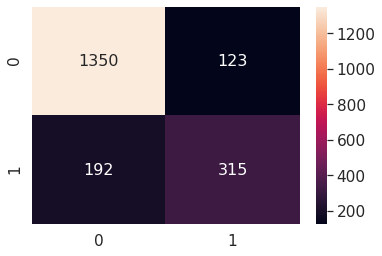

In [67]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_train,y_train)
y_pred =LR.predict(x_val)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_val, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_val, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_val, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_val, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_val, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### L1 reg

In [68]:
LR = LogisticRegression(penalty='l1', solver='liblinear')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.2s finished


Best HyperParameter:  {'C': 100}
0.8568489231086944


Accuracy on test set: 84.697%
Precision on test set: 0.805
Recall on test set: 0.780
F1-Score on test set: 0.791


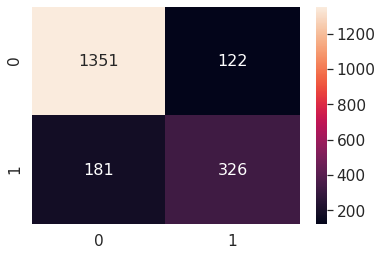

In [69]:
LR= LogisticRegression(penalty='l1', solver='liblinear',C=optimal_C)
LR.fit(x_train,y_train)
y_pred =LR.predict(x_val)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_val, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_val, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_val, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_val, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_val, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Data cleaning

In [6]:
# combined all tweets and join with space
combined_tweets = ' '.join(data.tweet.values)

# store all combined tweets into doc file
doc = nlp(combined_tweets)

###### get the top 20 word frequency

In [7]:
def gen_freq(tokens):

  word_freq = pd.Series([token.text for token in tokens]).value_counts()
  print(word_freq[:20])
  return word_freq

In [8]:
word_freq = gen_freq(doc)

#          47499
!           3530
.           3199
iphone      2383
I           2174
…           1955
my          1861
,           1853
to          1823
apple       1786
the         1720
a           1245
and         1192
iPhone      1182
Apple       1032
for         1032
it          1006
samsung      924
phone        892
...          870
dtype: int64


###### Visualise word frequency using wordcloud

In [9]:
!pip install wordcloud

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [11]:
print('No of unique words:', len(word_freq))

No of unique words: 26783


In [12]:
# create fuc to visualisa word frequqncy
def generate_wordcloud(data):

  wc = WordCloud(width=400, height=330, max_words=200, background_color='black').generate_from_frequencies(data)
  plt.figure(figsize=(14,12))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title("Top 200 most frequent unique words")
  plt.show()

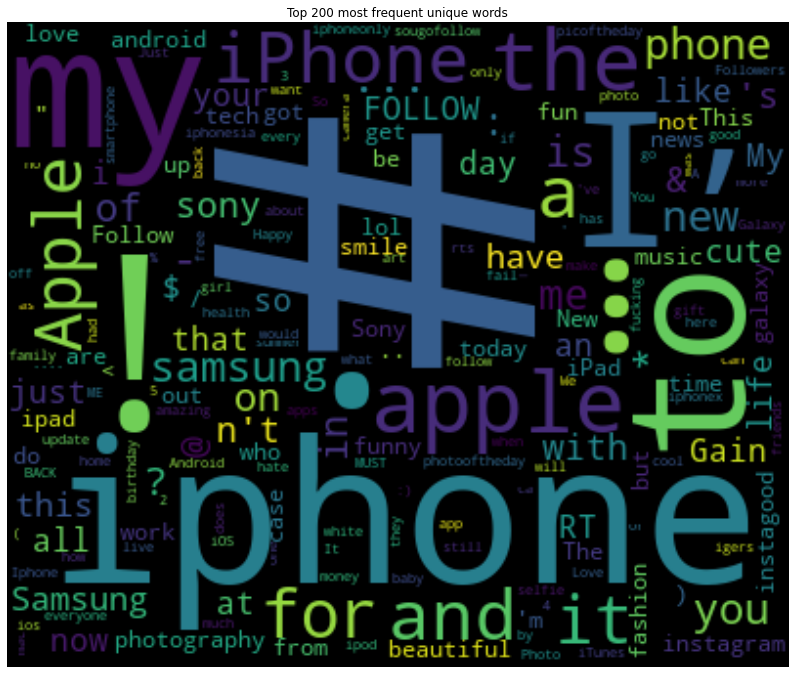

In [13]:
generate_wordcloud(word_freq)

#### Data clening using regex and wordcloud

In [14]:
import re

In [15]:
combined_tweets = " ".join([token.text for token in doc])

In [16]:
import string

remove = string.punctuation
remove = remove.replace("-", "") # don't remove hyphens
pattern = r"[{}]".format(remove) # create the pattern

txt = ")*^%{}[]thi's - is - @@#!a !%%!!%- test."
re.sub(pattern, "", txt) 
# >>> 'this - is - a - test'

'this - is - a - test'

In [17]:


def cleaned_text(combined_tweets):
  
  combined_tweets = combined_tweets.lower()
  combined_tweets = re.sub('@', '', combined_tweets)
  combined_tweets = re.sub('(RT|#)', '', combined_tweets)
  combined_tweets = re.sub('(\r\n|amp|<|>)+', '', combined_tweets)
  combined_tweets = re.sub('\d+', '', combined_tweets)
  combined_tweets = re.sub('https:/', '', combined_tweets)
  combined_tweets = re.sub('http', '', combined_tweets)
  combined_tweets = re.sub('/|/t.co', '', combined_tweets)
  combined_tweets = re.sub('t.co', '', combined_tweets)
  # fetch alphabetic characters
  combined_tweets = re.sub("[^a-zA-Z]", ' ', combined_tweets)
  #combined_tweets = re.sub(pattern, '', combined_tweets)
  combined_tweets = re.sub(r"\s+$", "", combined_tweets)
  combined_tweets = re.sub('\s+',' ', combined_tweets)
  #combined_tweets = re.sub('-','', combined_tweets)
  #combined_tweets = re.sub('...','', combined_tweets)
  doc = nlp(combined_tweets)
  tokens = [token.lemma_ for token in doc if(token.is_stop==False)]

  return ' '.join(tokens)


In [18]:
data['cleaned_tweet'] = data['tweet'].apply(cleaned_text)

In [19]:
data['cleaned_tweet'].head()

0    fingerprint pregnancy test goo glhmfqv android...
1    finally transparant silicon case thank uncle y...
2    love talk makememorie unplug relax iphone smar...
3    m wire know m george way iphone cute daventry ...
4    amazing service apple win t talk question pay ...
Name: cleaned_tweet, dtype: object

In [20]:
combined_cleantweet = ' '.join(data.cleaned_tweet.values)
cleaned_doc = nlp(combined_cleantweet)

In [21]:
cleaned_word_freq = gen_freq(cleaned_doc)

iphone       4237
apple        3004
instagram    2183
samsung      1441
new          1166
twitter      1111
phone        1060
s            1047
sony          853
instagr       789
follow        732
t             652
www           614
pic           614
ipad          550
love          510
like          465
day           443
life          422
android       420
dtype: int64


In [22]:
print('No of unique words:', len(cleaned_word_freq))

No of unique words: 20822


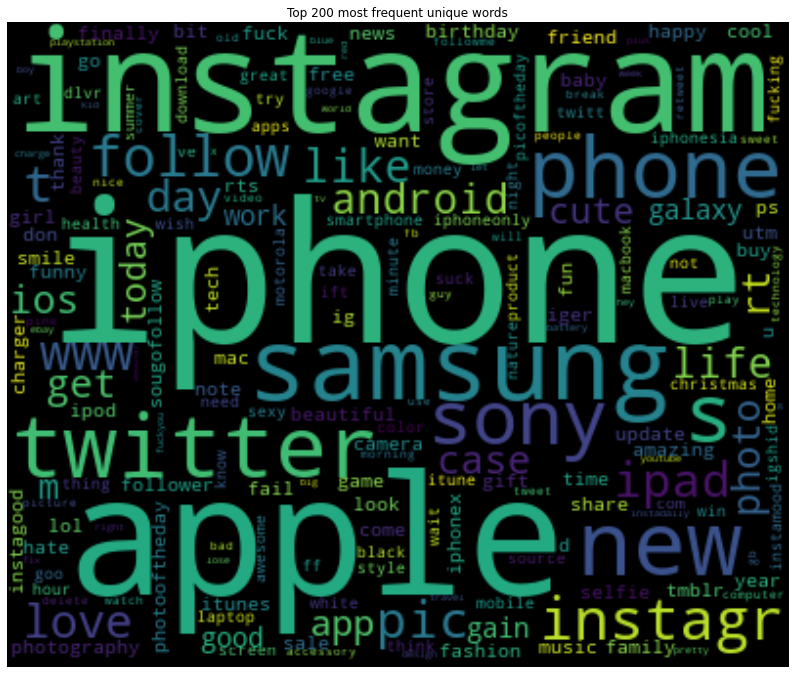

In [23]:
generate_wordcloud(cleaned_word_freq)

In [24]:
data.head()

,id,label,tweet,cleaned_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test goo glhmfqv android...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thank uncle y...
2,3,0,We love this! Would you go? #talk #makememorie...,love talk makememorie unplug relax iphone smar...
3,4,0,I'm wired I know I'm George I was made that wa...,m wire know m george way iphone cute daventry ...
4,5,1,What amazing service! Apple won't even talk to...,amazing service apple win t talk question pay ...


#### Feature enginerring 
 * create length features 

In [91]:
data['word_count_cleaned'] = data['cleaned_tweet'].apply(lambda x: len(x.split()))
word_count_cleaned_target = data.groupby('label')['word_count_cleaned'].mean().reset_index()
data = data.merge(word_count_cleaned_target,on='label',how='left')

data['char_count_cleaned'] = data['cleaned_tweet'].apply(lambda x: len(x))
char_count_cleaned_target = data.groupby('label')['char_count_cleaned'].mean().reset_index()
data = data.merge(char_count_cleaned_target,on='label',how='left')

data['char_count_without_spaces'] = data['cleaned_tweet'].apply(lambda x: len(x.replace(" ","")))
char_count_without_spaces= data.groupby('label')['char_count_without_spaces'].mean().reset_index()
data = data.merge(char_count_without_spaces,on='label',how='left')

In [92]:
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_tweet,word_count_cleaned_x,word_count_cleaned_y,char_count_cleaned_x,char_count_cleaned_y,char_count_without_spaces_x,char_count_without_spaces_y
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077,128,0,116,fingerprint pregnancy test goo glhmfqv android...,14,14.204276,106,100.437394,93,87.168646
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706,131,0,115,finally transparant silicon case thank uncle y...,13,14.204276,98,100.437394,86,87.168646
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667,123,0,109,love talk makememorie unplug relax iphone smar...,11,14.204276,78,100.437394,68,87.168646
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059,112,0,96,m wire know m george way iphone cute daventry ...,13,14.204276,69,100.437394,57,87.168646
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783,124,0,102,amazing service apple win t talk question pay ...,10,10.000000,60,62.297137,51,53.249753


#### Getting sentiment score beased on cleaned tweets

In [93]:
c_tweet = data['cleaned_tweet'].to_list()
print(c_tweet[1])

finally transparant silicon case thank uncle yay sony xperia s sonyexperias instagram compygetjcjm


In [94]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [95]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [96]:
from tqdm import tqdm
nltk_results = [nltk_sentiment(row) for row in tqdm(c_tweet)]

100%|██████████| 7920/7920 [00:51<00:00, 153.75it/s]


In [97]:
tweet_sentiment = pd.DataFrame(nltk_results)
tweet_sentiment.head(2)

,neg,neu,pos,compound
0,0.0,0.635,0.365,0.7845
1,0.0,0.629,0.371,0.7096


In [98]:
tweet_sentiment.shape

(7920, 4)

In [99]:
data = pd.concat([data, tweet_sentiment], axis=1)
data.head()

,id,label,tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_tweet,word_count_cleaned_x,word_count_cleaned_y,char_count_cleaned_x,char_count_cleaned_y,char_count_without_spaces_x,char_count_without_spaces_y,neg,neu,pos,compound
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,11,0,13,0,5,17,8.923077,128,0,116,fingerprint pregnancy test goo glhmfqv android...,14,14.204276,106,100.437394,93,87.168646,0.000,0.635,0.365,0.7845
1,2,0,Finally a transparant silicon case ^^ Thanks t...,0,5,0,17,3,2,8,6.764706,131,0,115,finally transparant silicon case thank uncle y...,13,14.204276,98,100.437394,86,87.168646,0.000,0.629,0.371,0.7096
2,3,0,We love this! Would you go? #talk #makememorie...,0,8,0,15,5,2,12,7.266667,123,0,109,love talk makememorie unplug relax iphone smar...,11,14.204276,78,100.437394,68,87.168646,0.000,0.559,0.441,0.7964
3,4,0,I'm wired I know I'm George I was made that wa...,0,4,0,17,9,1,8,5.647059,112,0,96,m wire know m george way iphone cute daventry ...,13,14.204276,69,100.437394,57,87.168646,0.000,0.769,0.231,0.4588
4,5,1,What amazing service! Apple won't even talk to...,0,0,0,23,14,2,8,4.434783,124,0,102,amazing service apple win t talk question pay ...,10,10.000000,60,62.297137,51,53.249753,0.251,0.209,0.539,0.7579


In [100]:
data.isnull().sum()

id                             0
label                          0
tweet                          0
mentions_count                 0
hashtags_count                 0
title_count                    0
word_count                     0
stopword_count                 0
ner                            0
pos                            0
avg_word_len                   0
char_count                     0
num_digit                      0
char_count_without_space       0
cleaned_tweet                  0
word_count_cleaned_x           0
word_count_cleaned_y           0
char_count_cleaned_x           0
char_count_cleaned_y           0
char_count_without_spaces_x    0
char_count_without_spaces_y    0
neg                            0
neu                            0
pos                            0
compound                       0
dtype: int64

#### Data normalisation for numerical columns

In [ ]:
norm_data = data[['mentions_count',	'hashtags_count',	'title_count',	'word_count',	'stopword_count',	'ner',	'pos',	'avg_word_len',	'char_count',	'num_digit',	'char_count_without_space',	
                  'word_count_cleaned_x',	'word_count_cleaned_y',	'char_count_cleaned_x',	'char_count_cleaned_y',	'char_count_without_spaces_x',	'char_count_without_spaces_y',	'neg',	'neu',	'pos',	'compound'
                  ]]

In [ ]:
# applying for loop to bring all the variables in range 0 to 1

for i in norm_data.columns[0:]:
    norm_data[i] = (norm_data[i] - norm_data[i].min()) / (norm_data[i].max() - norm_data[i].min())

In [ ]:
norm_data.head()

,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,pos,avg_word_len,char_count,num_digit,char_count_without_space,word_count_cleaned_x,word_count_cleaned_y,char_count_cleaned_x,char_count_cleaned_y,char_count_without_spaces_x,char_count_without_spaces_y,neg,neu,pos,pos,compound
0,0.0,0.333333,0.0,0.222222,0.000000,0.357143,0.320755,0.414773,0.298643,0.309463,0.0,0.300275,0.265306,1.0,0.310769,1.0,0.305556,1.0,0.000,0.635,0.320755,0.414773,0.897372
1,0.0,0.151515,0.0,0.296296,0.081081,0.142857,0.150943,0.421591,0.189817,0.317136,0.0,0.297521,0.244898,1.0,0.286154,1.0,0.281250,1.0,0.000,0.629,0.150943,0.421591,0.858706
2,0.0,0.242424,0.0,0.259259,0.135135,0.142857,0.226415,0.501136,0.215126,0.296675,0.0,0.280992,0.204082,1.0,0.224615,1.0,0.218750,1.0,0.000,0.559,0.226415,0.501136,0.903516
3,0.0,0.121212,0.0,0.296296,0.243243,0.071429,0.150943,0.262500,0.133465,0.268542,0.0,0.245179,0.244898,1.0,0.196923,1.0,0.180556,1.0,0.000,0.769,0.150943,0.262500,0.729234
4,0.0,0.000000,0.0,0.407407,0.378378,0.142857,0.150943,0.612500,0.072342,0.299233,0.0,0.261708,0.183673,0.0,0.169231,0.0,0.159722,0.0,0.251,0.209,0.150943,0.612500,0.883640


In [ ]:
data = data.drop(['id', 'tweet', 'mentions_count',	'hashtags_count',	'title_count',	'word_count',	'stopword_count',	'ner',	'pos',	'avg_word_len',	'char_count',	'num_digit',	'char_count_without_space',	
                  'word_count_cleaned_x',	'word_count_cleaned_y',	'char_count_cleaned_x',	'char_count_cleaned_y',	'char_count_without_spaces_x',	'char_count_without_spaces_y',	'neg',	'neu',	'pos',	'compound'], axis=1)

In [ ]:
data.head()

,label,cleaned_tweet
0,0,fingerprint pregnancy test goo glhmfqv android...
1,0,finally transparant silicon case thank uncle y...
2,0,love talk makememorie unplug relax iphone smar...
3,0,m wire know m george way iphone cute daventry ...
4,1,amazing service apple win t talk question pay ...


In [ ]:
data = pd.concat([data,norm_data], axis=1)

In [ ]:
data.head()

,label,cleaned_tweet,mentions_count,hashtags_count,title_count,word_count,stopword_count,ner,pos,pos,avg_word_len,char_count,num_digit,char_count_without_space,word_count_cleaned_x,word_count_cleaned_y,char_count_cleaned_x,char_count_cleaned_y,char_count_without_spaces_x,char_count_without_spaces_y,neg,neu,pos,pos,compound
0,0,fingerprint pregnancy test goo glhmfqv android...,0.0,0.333333,0.0,0.222222,0.000000,0.357143,0.320755,0.414773,0.298643,0.309463,0.0,0.300275,0.265306,1.0,0.310769,1.0,0.305556,1.0,0.000,0.635,0.320755,0.414773,0.897372
1,0,finally transparant silicon case thank uncle y...,0.0,0.151515,0.0,0.296296,0.081081,0.142857,0.150943,0.421591,0.189817,0.317136,0.0,0.297521,0.244898,1.0,0.286154,1.0,0.281250,1.0,0.000,0.629,0.150943,0.421591,0.858706
2,0,love talk makememorie unplug relax iphone smar...,0.0,0.242424,0.0,0.259259,0.135135,0.142857,0.226415,0.501136,0.215126,0.296675,0.0,0.280992,0.204082,1.0,0.224615,1.0,0.218750,1.0,0.000,0.559,0.226415,0.501136,0.903516
3,0,m wire know m george way iphone cute daventry ...,0.0,0.121212,0.0,0.296296,0.243243,0.071429,0.150943,0.262500,0.133465,0.268542,0.0,0.245179,0.244898,1.0,0.196923,1.0,0.180556,1.0,0.000,0.769,0.150943,0.262500,0.729234
4,1,amazing service apple win t talk question pay ...,0.0,0.000000,0.0,0.407407,0.378378,0.142857,0.150943,0.612500,0.072342,0.299233,0.0,0.261708,0.183673,0.0,0.169231,0.0,0.159722,0.0,0.251,0.209,0.150943,0.612500,0.883640


#### Train test split

In [ ]:
y = data['label']
data.drop(['label'], axis=1, inplace=True)
X = data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [ ]:
print('X_train:',X_train.shape,'y_train:',y_train.shape)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

X_train: (6336, 24) y_train: (6336,)
X_test: (1584, 24) y_test: (1584,)


#### Bag of words

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer1.fit(X_train['cleaned_tweet'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleaned_tweet_bow = vectorizer1.transform(X_train['cleaned_tweet'].values)
X_test_cleaned_tweet_bow = vectorizer1.transform(X_test['cleaned_tweet'].values)

print("After vectorizations")
print(X_train_cleaned_tweet_bow.shape, y_train.shape)
print(X_test_cleaned_tweet_bow.shape, y_test.shape)
print("="*100)

(6336, 24) (6336,)
(1584, 24) (1584,)
After vectorizations
(6336, 1689) (6336,)
(1584, 1689) (1584,)


#### stack the dataframe

In [ ]:
X_train_norm = X_train[['mentions_count',	'hashtags_count',	'title_count',	'word_count',	'stopword_count',	'ner',	'pos',	'avg_word_len',	'char_count',	'num_digit',	'char_count_without_space',	
                  'word_count_cleaned_x',	'word_count_cleaned_y',	'char_count_cleaned_x',	'char_count_cleaned_y',	'char_count_without_spaces_x',	'char_count_without_spaces_y',	'neg',	'neu',	'pos',	'compound']]

X_test_norm = X_test[['mentions_count',	'hashtags_count',	'title_count',	'word_count',	'stopword_count',	'ner',	'pos',	'avg_word_len',	'char_count',	'num_digit',	'char_count_without_space',	
                  'word_count_cleaned_x',	'word_count_cleaned_y',	'char_count_cleaned_x',	'char_count_cleaned_y',	'char_count_without_spaces_x',	'char_count_without_spaces_y',	'neg',	'neu',	'pos',	'compound']]

In [ ]:
X_train_n = X_train_norm.to_numpy()
X_test_n = X_test_norm.to_numpy()

In [ ]:
print(X_train_n.shape)
print(X_test_n.shape)

(6336, 27)
(1584, 27)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_cleaned_tweet_bow, X_train_n)).tocsr()
X_te = hstack((X_test_cleaned_tweet_bow, X_test_n)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(6336, 1716) (6336,)
(1584, 1716) (1584,)


#### Model building using bag of word

In [ ]:
# Importing for modeling
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

#### Naive bayes

In [ ]:
# Training model
nb_model=MultinomialNB().fit(X_tr,y_train)
nb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# Make predictions for train set
train_pred_nb=nb_model.predict(X_tr)

In [ ]:
train_pred_nb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_nb,average="weighted"))

F1-score on Train Set: 0.9933493805447312


In [ ]:
# Make predictions for validation set
val_pred_nb=nb_model.predict(X_te)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_test,val_pred_nb,average="weighted"))

F1-score on Validation Set: 0.9936765489297515


#### Logistic regression

In [ ]:
# Training model
lr_model=LogisticRegression().fit(X_tr,y_train)
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make predictions for train set
train_pred_lr=lr_model.predict(X_tr)
train_pred_nb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_lr,average="weighted"))

F1-score on Train Set: 1.0


In [ ]:
# Make predictions for validation set
val_pred_lr=lr_model.predict(X_te)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_test,val_pred_lr,average="weighted"))

F1-score on Validation Set: 1.0


#### SGD classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
LR = LogisticRegression(penalty='l2')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(X_tr,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.8s finished


Best HyperParameter:  {'C': 0.01}
1.0


Accuracy on test set: 100.000%
Precision on test set: 1.000
Recall on test set: 1.000
F1-Score on test set: 1.000


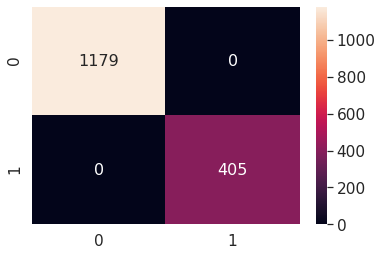

In [ ]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(X_tr,y_train)
y_pred =LR.predict(X_te)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [ ]:
LR = LogisticRegression(penalty='l1', solver='liblinear')
C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(X_tr,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best HyperParameter:  {'C': 0.01}
1.0


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished


Accuracy on test set: 100.000%
Precision on test set: 1.000
Recall on test set: 1.000
F1-Score on test set: 1.000


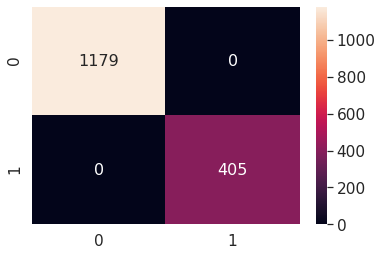

In [ ]:
LR= LogisticRegression(penalty='l1', solver='liblinear',C=optimal_C)
LR.fit(X_tr,y_train)
y_pred =LR.predict(X_te)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### TF-IDF

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)


vectorizer21 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer21.fit(X_train['cleaned_tweet'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleaned_tweet_tfidf = vectorizer21.transform(X_train['cleaned_tweet'].values)
X_test_cleaned_tweet_tfidf = vectorizer21.transform(X_test['cleaned_tweet'].values)

print("After vectorizations")
print(X_train_cleaned_tweet_tfidf.shape, y_train.shape)
print(X_test_cleaned_tweet_tfidf.shape, y_test.shape)
print("="*100)

(6336, 24) (6336,)
(1584, 24) (1584,)
After vectorizations
(6336, 1689) (6336,)
(1584, 1689) (1584,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_cleaned_tweet_tfidf, X_train_n)).tocsr()
X_te_tfidf = hstack((X_test_cleaned_tweet_tfidf, X_test_n)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(6336, 1716) (6336,)
(1584, 1716) (1584,)


#### Model building

#### naive bayes

In [ ]:
# Training model
nb_model=MultinomialNB().fit(X_tr_tfidf,y_train)
nb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# Make predictions for train set
train_pred_nb=nb_model.predict(X_tr_tfidf)

In [ ]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_nb,average="weighted"))

F1-score on Train Set: 0.9946150408740928


In [ ]:
# Make predictions for validation set
val_pred_nb=nb_model.predict(X_te_tfidf)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_test,val_pred_nb,average="weighted"))

F1-score on Validation Set: 0.9949328438681978


#### logisitc regression

In [ ]:
# Training model
lr_model=LogisticRegression().fit(X_tr_tfidf,y_train)
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make predictions for train set
train_pred_lr=lr_model.predict(X_tr_tfidf)
train_pred_nb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_lr,average="weighted"))

F1-score on Train Set: 1.0


In [ ]:
# Make predictions for validation set
val_pred_lr=lr_model.predict(X_te_tfidf)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_test,val_pred_lr,average="weighted"))

F1-score on Validation Set: 1.0


#### XG boost

In [ ]:
#Importing XGBM Classifier 
from xgboost import XGBClassifier

In [ ]:
#set parameters
clf = XGBClassifier(random_state=96, colsample_bytree=0.7, max_depth=6, gamma=0.1)

In [ ]:
#training the model
clf.fit(X_tr_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=96,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Make predictions for train set
train_pred_XG=clf.predict(X_tr_tfidf)
train_pred_nb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_XG,average="weighted"))

F1-score on Train Set: 1.0


In [ ]:
# Make predictions for validation set
val_pred_XG=clf.predict(X_te_tfidf)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_test,val_pred_XG,average="weighted"))

F1-score on Validation Set: 1.0


In [68]:
data.to_csv('tp_data.csv')
!cp tp_data.csv "/content/drive/MyDrive/NLP_datasets/tp_data.csv"

In [4]:
rnn_data = data[['cleaned_tweet', 'label']]
lstm_data = data[['cleaned_tweet', 'label']]
gru_data = data[['cleaned_tweet', 'label']]
cnn_data = data[['cleaned_tweet', 'label']]

#### RNN

In [5]:
rnn_data.head()

,cleaned_tweet,label
0,fingerprint pregnancy test goo glhmfqv android...,0
1,finally transparant silicon case thank uncle y...,0
2,love talk makememorie unplug relax iphone smar...,0
3,m wire know m george way iphone cute daventry ...,0
4,amazing service apple win t talk question pay ...,1


In [6]:
X = rnn_data['cleaned_tweet']
y = rnn_data['label']

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

y = lb.fit_transform(y)
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [25]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(X,y,test_size=0.2, stratify=y, random_state=0, shuffle=True)

In [28]:
print(x_tr.shape,y_tr.shape)
print(x_val.shape,y_val.shape)

(6336,) (6336, 1)
(1584,) (1584, 1)


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer()

x_tokenizer.fit_on_texts(x_tr)

In [12]:
x_tokenizer.word_index

{'iphone': 1,
 'apple': 2,
 'instagram': 3,
 'samsung': 4,
 'new': 5,
 'twitter': 6,
 's': 7,
 'phone': 8,
 'sony': 9,
 'instagr': 10,
 'follow': 11,
 't': 12,
 'pic': 13,
 'www': 14,
 'ipad': 15,
 'love': 16,
 'like': 17,
 'day': 18,
 'android': 19,
 'life': 20,
 'ios': 21,
 'case': 22,
 'rt': 23,
 'get': 24,
 'photo': 25,
 'app': 26,
 'm': 27,
 'cute': 28,
 'good': 29,
 'gain': 30,
 'galaxy': 31,
 'today': 32,
 'work': 33,
 'photography': 34,
 'fun': 35,
 'news': 36,
 'music': 37,
 'time': 38,
 'instagood': 39,
 'bit': 40,
 'thank': 41,
 'update': 42,
 'smile': 43,
 'happy': 44,
 'fashion': 45,
 'beautiful': 46,
 'lol': 47,
 'funny': 48,
 'girl': 49,
 'go': 50,
 'tech': 51,
 'utm': 52,
 'birthday': 53,
 'ps': 54,
 'ipod': 55,
 'iphonex': 56,
 'finally': 57,
 'd': 58,
 'selfie': 59,
 'photooftheday': 60,
 'amazing': 61,
 'friend': 62,
 'fuck': 63,
 'buy': 64,
 'share': 65,
 'note': 66,
 'ig': 67,
 'gift': 68,
 'game': 69,
 'want': 70,
 'fail': 71,
 'follower': 72,
 'mac': 73,
 'sougof

In [13]:
len(x_tokenizer.word_index)

17706

In [14]:
thresh =3

cnt = 0

for key,value in x_tokenizer.word_counts.items():
  if value>=thresh:
    cnt += 1
print(cnt)

3120


In [15]:
x_tokenizer = Tokenizer(num_words=cnt, oov_token='unk')

x_tokenizer.fit_on_texts(x_tr)

In [16]:
max_len = 100

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

In [17]:
x_tr_seq = pad_sequences(x_tr_seq, padding='post', maxlen=max_len)
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len)

In [18]:
x_voc_size = x_tokenizer.num_words + 1
x_voc_size

3121

In [19]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

#### RNN

In [29]:
model = Sequential()

model.add(Embedding(x_voc_size, 50, input_shape=(max_len,), mask_zero=True))

model.add(SimpleRNN(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           156050    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               22912     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 195,603
Trainable params: 195,603
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [32]:
mc = ModelCheckpoint('weight.best.hdf5', monitor='val_loss', verboss=1, save_best_only=True, mode='min')

In [33]:
model.fit(x_tr_seq, y_tr, batch_size=50, epochs=10, verbose=1, validation_data=(x_val_seq, y_val), callbacks=[mc])

Epoch 1/10
127/127 [==============================] - 18s 114ms/step - loss: 0.5951 - val_loss: 0.5696
Epoch 2/10
127/127 [==============================] - 15s 115ms/step - loss: 0.5476 - val_loss: 0.5809
Epoch 3/10
127/127 [==============================] - 15s 115ms/step - loss: 0.4875 - val_loss: 0.6356
Epoch 4/10
127/127 [==============================] - 14s 112ms/step - loss: 0.3601 - val_loss: 0.8002
Epoch 5/10
127/127 [==============================] - 15s 114ms/step - loss: 0.2478 - val_loss: 0.9775
Epoch 6/10
127/127 [==============================] - 14s 114ms/step - loss: 0.1712 - val_loss: 1.3819
Epoch 7/10
127/127 [==============================] - 14s 113ms/step - loss: 0.1196 - val_loss: 1.4644
Epoch 8/10
127/127 [==============================] - 14s 113ms/step - loss: 0.0903 - val_loss: 1.6520
Epoch 9/10
127/127 [==============================] - 14s 114ms/step - loss: 0.0766 - val_loss: 1.3371
Epoch 10/10
127/127 [==============================] - 14s 114ms/step - l